In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.feature_selection import mutual_info_regression
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Energi

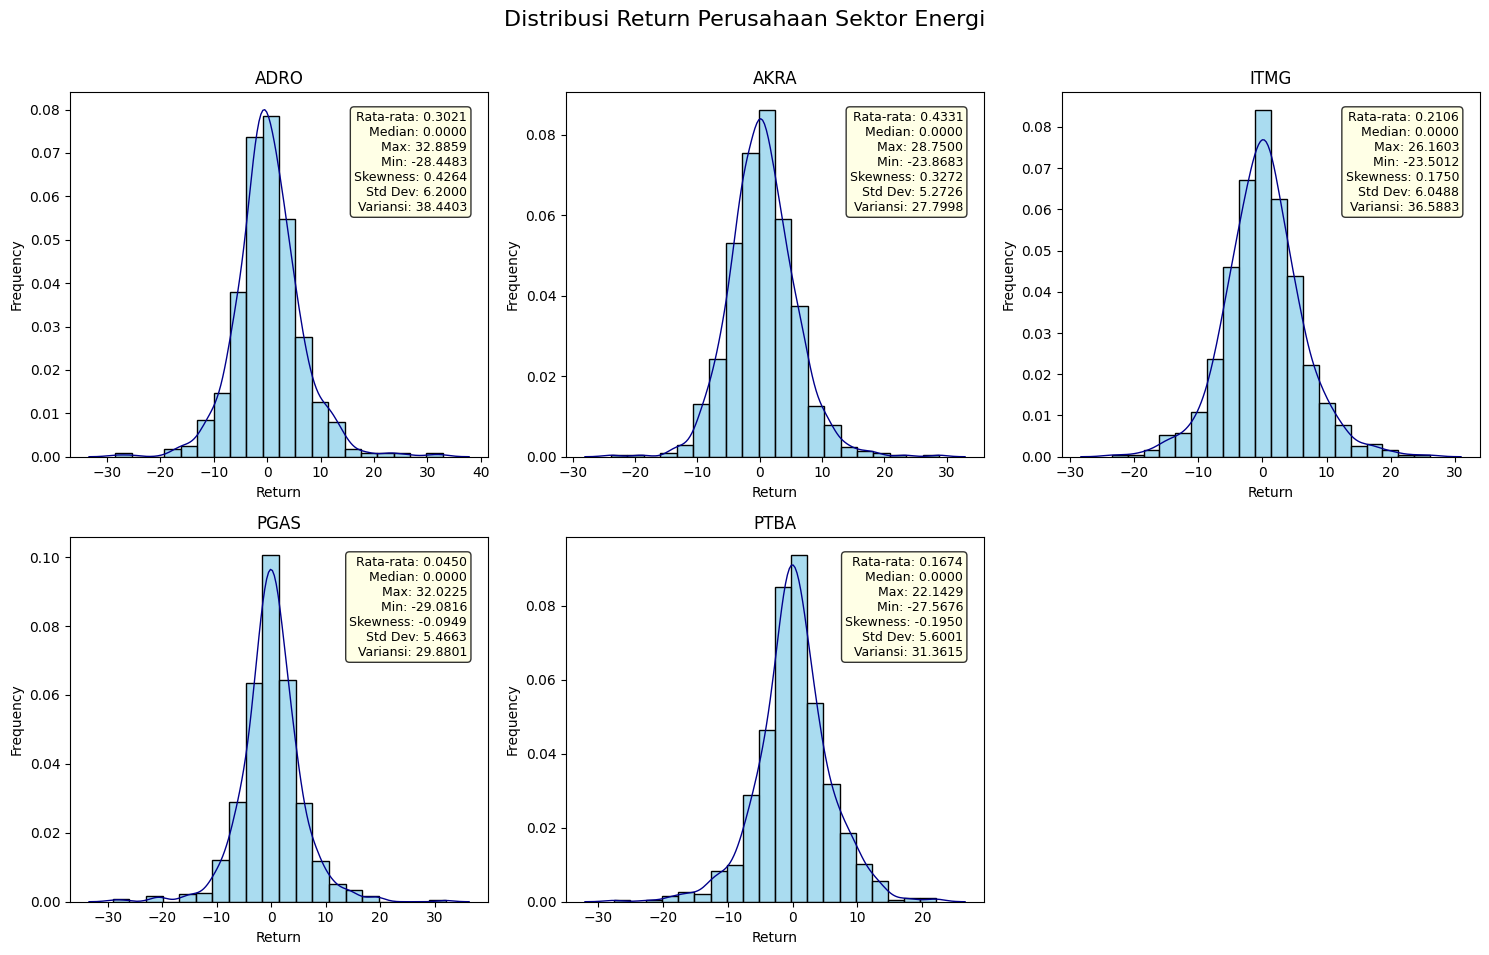

In [ ]:
company_returns = {}
company_names = ['ADRO', 'AKRA','ITMG','PGAS','PTBA']

file_paths = [fr'/content/{company}_FINAL.xlsx' for company in company_names]

for file_path, company_name in zip(file_paths, company_names):
    data = pd.read_excel(file_path)

    data['Return'] = data['Close'].pct_change()*100
    company_returns[company_name] = data['Return'].dropna()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))  `
fig.suptitle('Distribusi Return Perusahaan Sektor Energi', fontsize=16)

axes = axes.flatten()

for idx, (company_name, returns) in enumerate(company_returns.items()):
    sns.histplot(returns, bins=20, kde=False, ax=axes[idx], color='skyblue', edgecolor='black', alpha=0.7, stat='density')
    sns.kdeplot(returns, ax=axes[idx], color='darkblue', linewidth=1)

    avg_return = returns.mean()
    median_return = returns.median()
    max_return = returns.max()
    min_return = returns.min()
    skewness = skew(returns)
    std_dev = returns.std()
    variance = returns.var()

    stats_text = (
        f'Rata-rata: {avg_return:.4f}\n'
        f'Median: {median_return:.4f}\n'
        f'Max: {max_return:.4f}\n'
        f'Min: {min_return:.4f}\n'
        f'Skewness: {skewness:.4f}\n'
        f'Std Dev: {std_dev:.4f}\n'
        f'Variansi: {variance:.4f}'
    )
    props = dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightyellow', alpha=0.8)
    axes[idx].text(0.95, 0.95, stats_text, transform=axes[idx].transAxes, fontsize=9,
                   verticalalignment='top', horizontalalignment='right', bbox=props, color='black')

    axes[idx].set_title(company_name, fontsize=12, fontweight='light')
    axes[idx].set_xlabel('Return')
    axes[idx].set_ylabel('Frequency')

for i in range(len(company_returns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


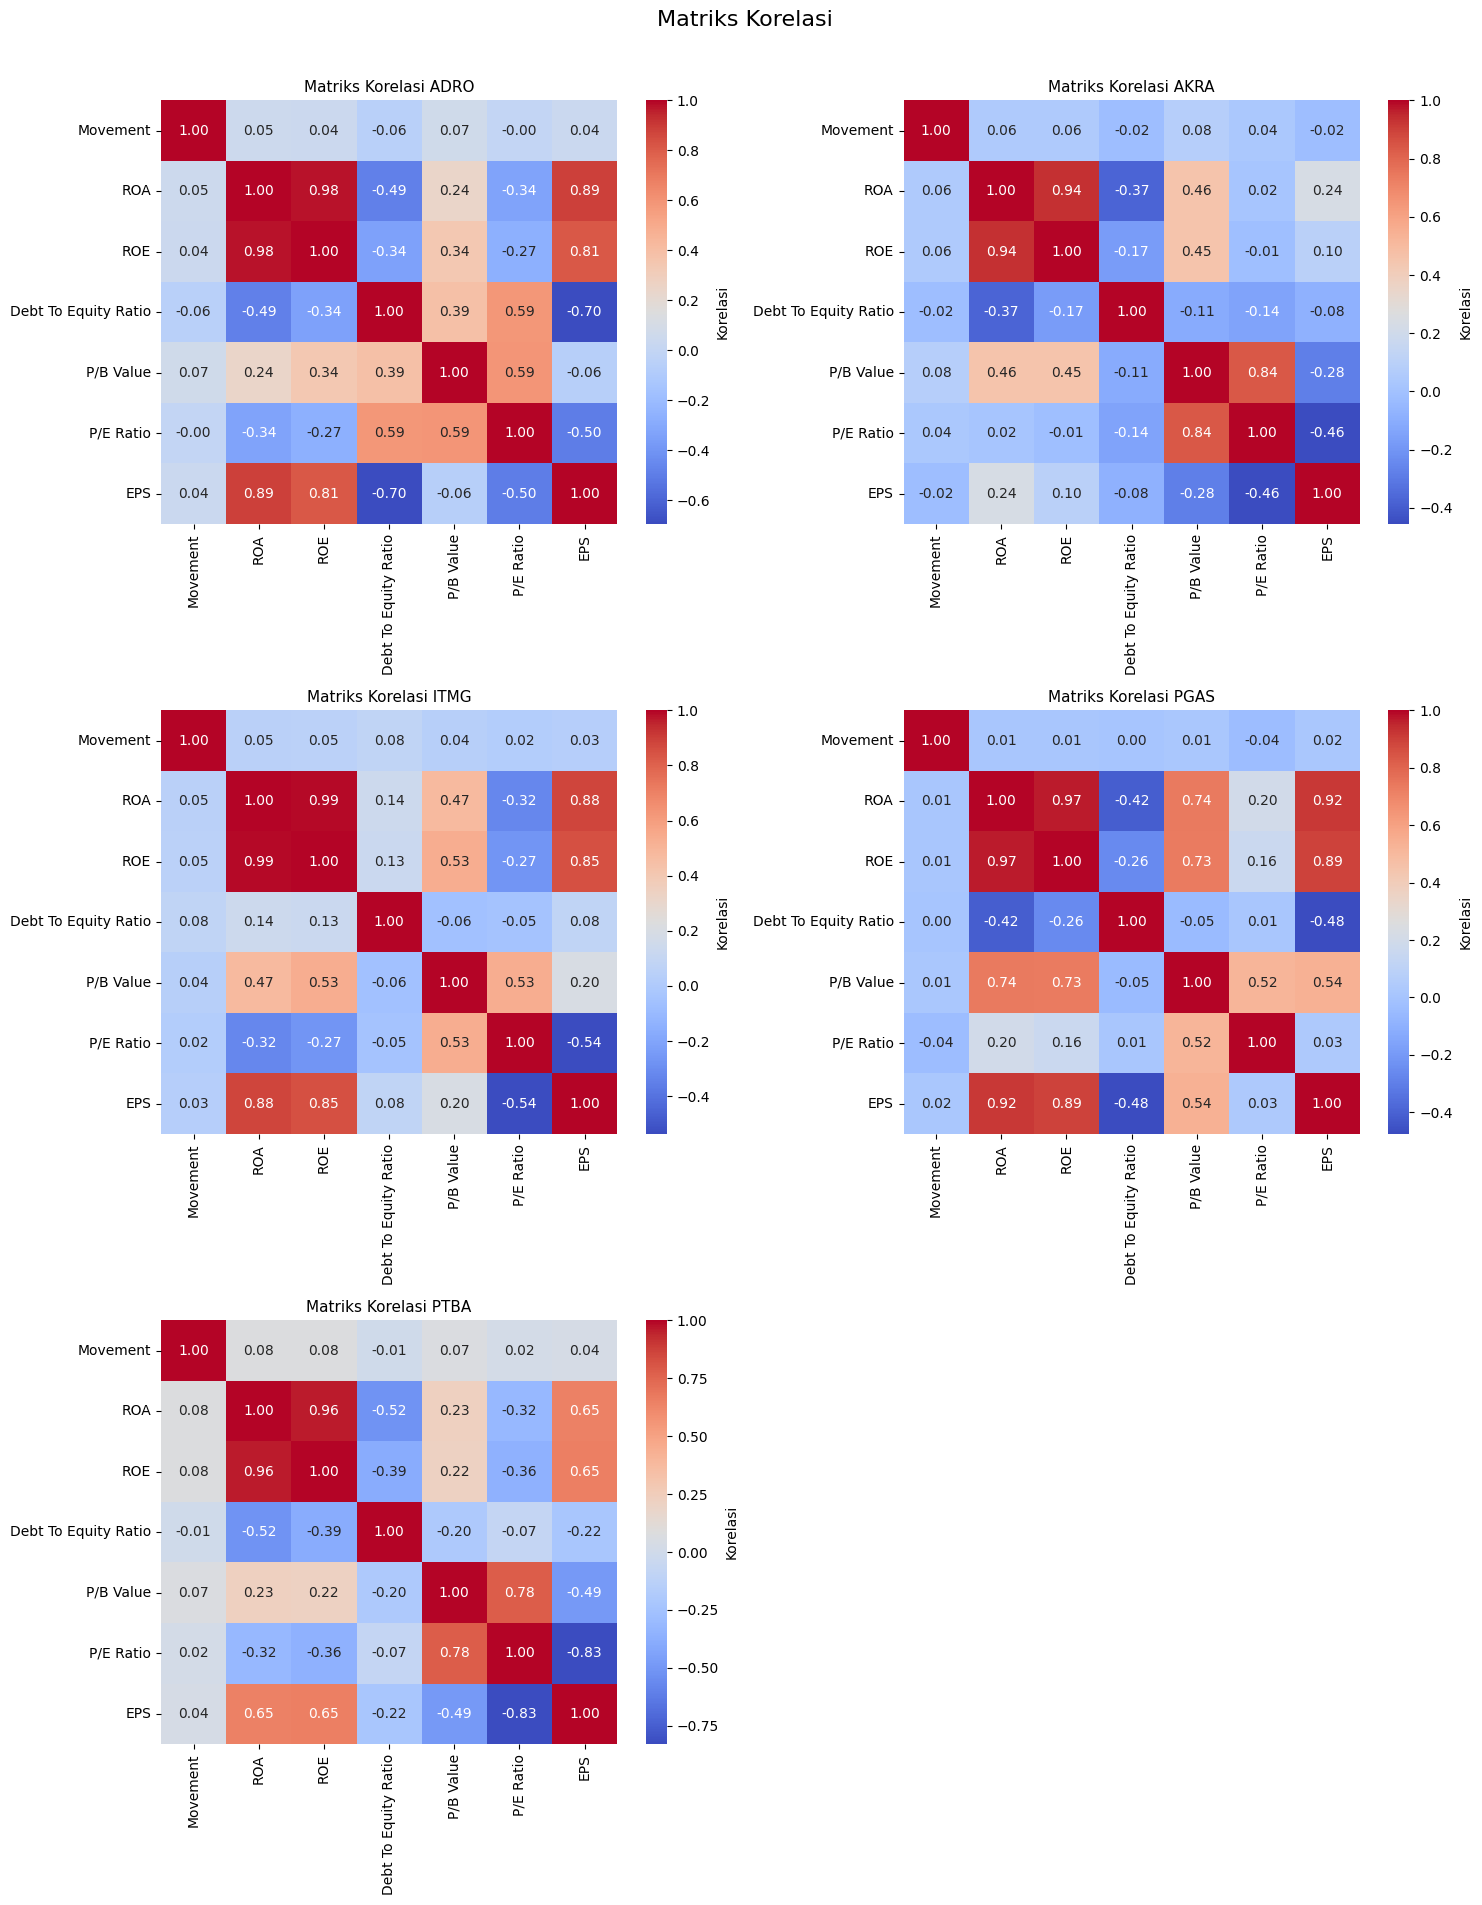

In [ ]:
# Loop through each file path, read the file, calculate returns, add 'movement', and store them
for file_path, company_name in zip(file_paths, company_names):
    # Read the Excel file
    data = pd.read_excel(file_path)

    # Calculate returns from the 'Close' column
    data['Return'] = data['Close'].pct_change() * 100

    # Add 'movement' column based on threshold 2
    data['Movement'] = data['Return'].apply(
        lambda x: 1 if x > 2 else (-1 if x < -2 else 0)
    )

    # Store the data in the dictionary
    company_returns[company_name] = data

# Set up the figure for plotting without shared x-axis
fig, axes = plt.subplots(3, 2, figsize=(15, 20))  # Removed `sharex=True`
fig.suptitle('Matriks Korelasi', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each company's correlation matrix
for idx, (company_name, data) in enumerate(company_returns.items()):
    # Select only numeric columns and drop 'Close' column
    numeric_data = data.select_dtypes(include=['number']).drop(columns=['Close', 'Return'])

    # Reorder columns: 'Return' and 'movement' first, and 'EPS' last (if 'EPS' exists)
    if 'EPS' in numeric_data.columns:
        cols = ['Movement'] + [col for col in numeric_data.columns if col not in ['Movement', 'EPS']] + ['EPS']
    else:
        cols = ['Movement'] + [col for col in numeric_data.columns if col not in ['Movement']]

    # Reorder columns in DataFrame
    numeric_data = numeric_data[cols]

    # Calculate correlation matrix using Spearman method
    correlation_matrix = numeric_data.corr(method='spearman')

    # Plot the heatmap of the correlation matrix
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[idx], cbar_kws={'label': 'Korelasi'})

    # Set title
    axes[idx].set_title(f'Matriks Korelasi {company_name}', fontsize=11, fontweight='light')

# Hide any remaining unused subplots
for i in range(len(company_returns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

<ipython-input-44-c01d3a21ceec>:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


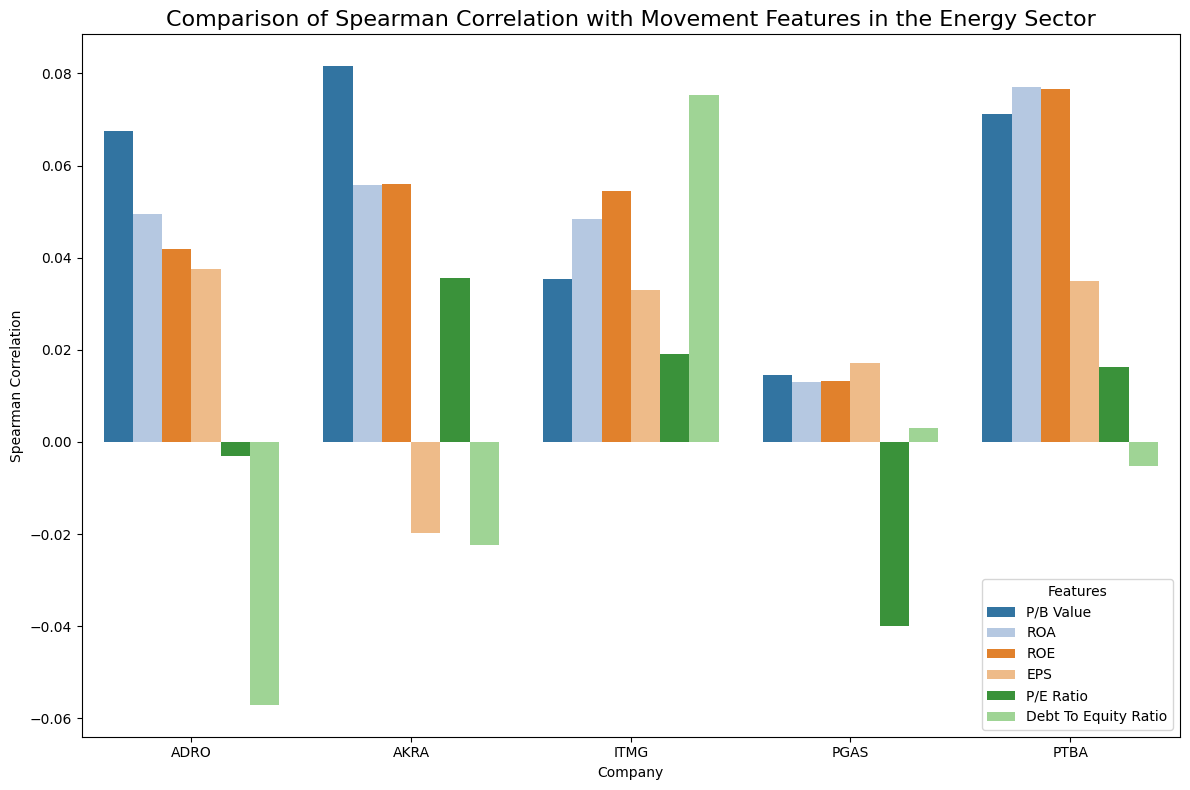

In [ ]:
# Dictionary to store correlation results for bar chart
correlation_results = {}

# Loop through each company's data to calculate correlations
for company_name, data in company_returns.items():
    # Select only numeric columns and drop irrelevant ones
    numeric_data = data.select_dtypes(include=['number']).drop(columns=['Close', 'Return'], errors='ignore')

    # Calculate correlation matrix using Spearman method
    correlation_matrix = numeric_data.corr(method='spearman')

    # Extract correlation of features with 'Movement' column
    movement_correlation = correlation_matrix['Movement'].drop('Movement', errors='ignore')
    correlation_results[company_name] = movement_correlation

# Convert the dictionary into a DataFrame for plotting
correlation_df = pd.DataFrame(correlation_results)

# Calculate the average correlation for each feature
correlation_df['Average'] = correlation_df.mean(axis=1)

# Sort features by their average correlation
sorted_features = correlation_df.sort_values(by='Average', ascending=False).index

# Drop the "Average" column to exclude it from the plot
correlation_df = correlation_df.drop(columns=['Average'], errors='ignore')

# Transpose and reset index for easier plotting
correlation_df = correlation_df.T
correlation_df.index.name = 'Company'
correlation_df.reset_index(inplace=True)

# Melt the DataFrame to long format for grouped bar chart
correlation_long = correlation_df.melt(id_vars='Company', var_name='Feature', value_name='Correlation')

# Ensure features are ordered based on the sorted averages
correlation_long['Feature'] = pd.Categorical(correlation_long['Feature'], categories=sorted_features, ordered=True)

# Define custom colors for each feature
feature_colors = {
    'EPS': 'cornflowerblue',
    'ROA': 'turquoise',
    'ROE': 'palegreen',
    'P/B Value': 'lightseagreen',
    'P/E Ratio': 'slateblue',
    'Debt To Equity Ratio': 'deeppink'
}

# Plot the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    data=correlation_long,
    x='Company',
    y='Correlation',
    hue='Feature',
    ci=None,
    palette='tab20'
)

# Customize plot
plt.title('Comparison of Spearman Correlation with Movement Features in the Energy Sector', fontsize=16)
plt.ylabel('Spearman Correlation')
plt.xlabel('Company')
plt.legend(title='Features', loc='lower right', frameon=True)
plt.tight_layout()

# Show plot
plt.show()

# Keuangan

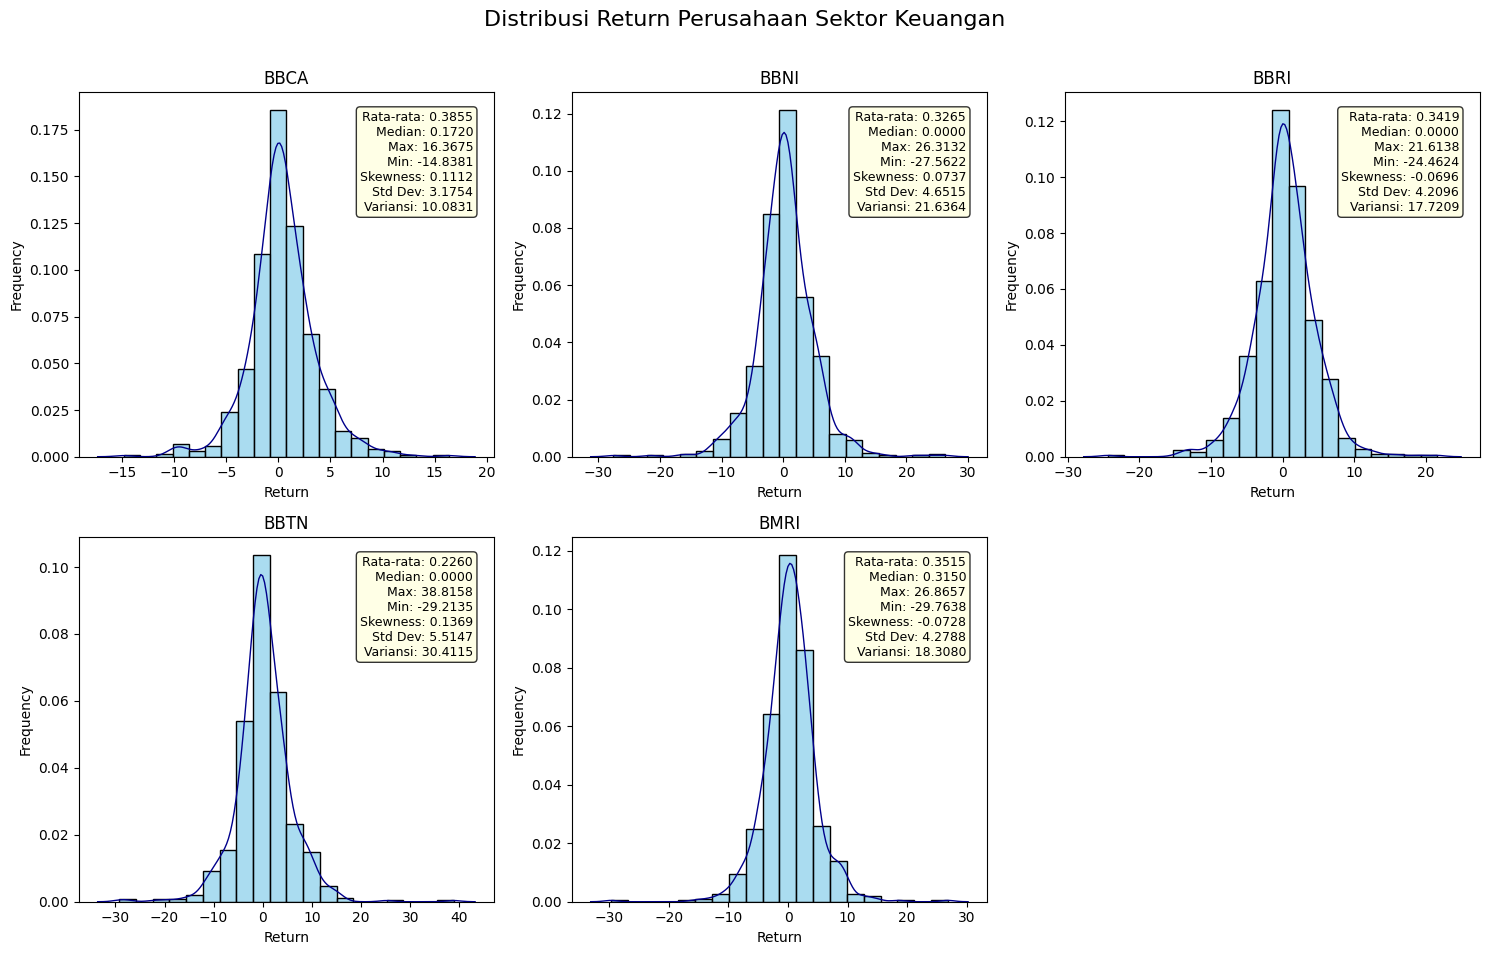

In [ ]:
company_returns = {}
company_names = ['BBCA','BBNI','BBRI','BBTN','BMRI']

file_paths = [fr'/content/{company}_FINAL.xlsx' for company in company_names]

# Loop through each file path, read the file, calculate returns, and store them
for file_path, company_name in zip(file_paths, company_names):
    # Read the Excel file
    data = pd.read_excel(file_path)

    # Calculate returns from the 'Close' column
    data['Return'] = data['Close'].pct_change()*100

    # Drop NaN values and store the result in the dictionary
    company_returns[company_name] = data['Return'].dropna()

# Set up the figure for plotting without shared x-axis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Removed `sharex=True`
fig.suptitle('Distribusi Return Perusahaan Sektor Keuangan', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each company's return distribution with customized KDE curve color
for idx, (company_name, returns) in enumerate(company_returns.items()):
    # Plot histogram with KDE
    sns.histplot(returns, bins=20, kde=False, ax=axes[idx], color='skyblue', edgecolor='black', alpha=0.7, stat='density')
    sns.kdeplot(returns, ax=axes[idx], color='darkblue', linewidth=1)

    # Calculate statistics
    avg_return = returns.mean()
    median_return = returns.median()
    max_return = returns.max()
    min_return = returns.min()
    skewness = skew(returns)
    std_dev = returns.std()
    variance = returns.var()

    # Annotate the statistics with enhanced formatting
    stats_text = (
        f'Rata-rata: {avg_return:.4f}\n'
        f'Median: {median_return:.4f}\n'
        f'Max: {max_return:.4f}\n'
        f'Min: {min_return:.4f}\n'
        f'Skewness: {skewness:.4f}\n'
        f'Std Dev: {std_dev:.4f}\n'
        f'Variansi: {variance:.4f}'
    )
    props = dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightyellow', alpha=0.8)
    axes[idx].text(0.95, 0.95, stats_text, transform=axes[idx].transAxes, fontsize=9,
                   verticalalignment='top', horizontalalignment='right', bbox=props, color='black')

    # Set title and labels
    axes[idx].set_title(company_name, fontsize=12, fontweight='light')
    axes[idx].set_xlabel('Return')
    axes[idx].set_ylabel('Frequency')

# Hide any remaining unused subplots
for i in range(len(company_returns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

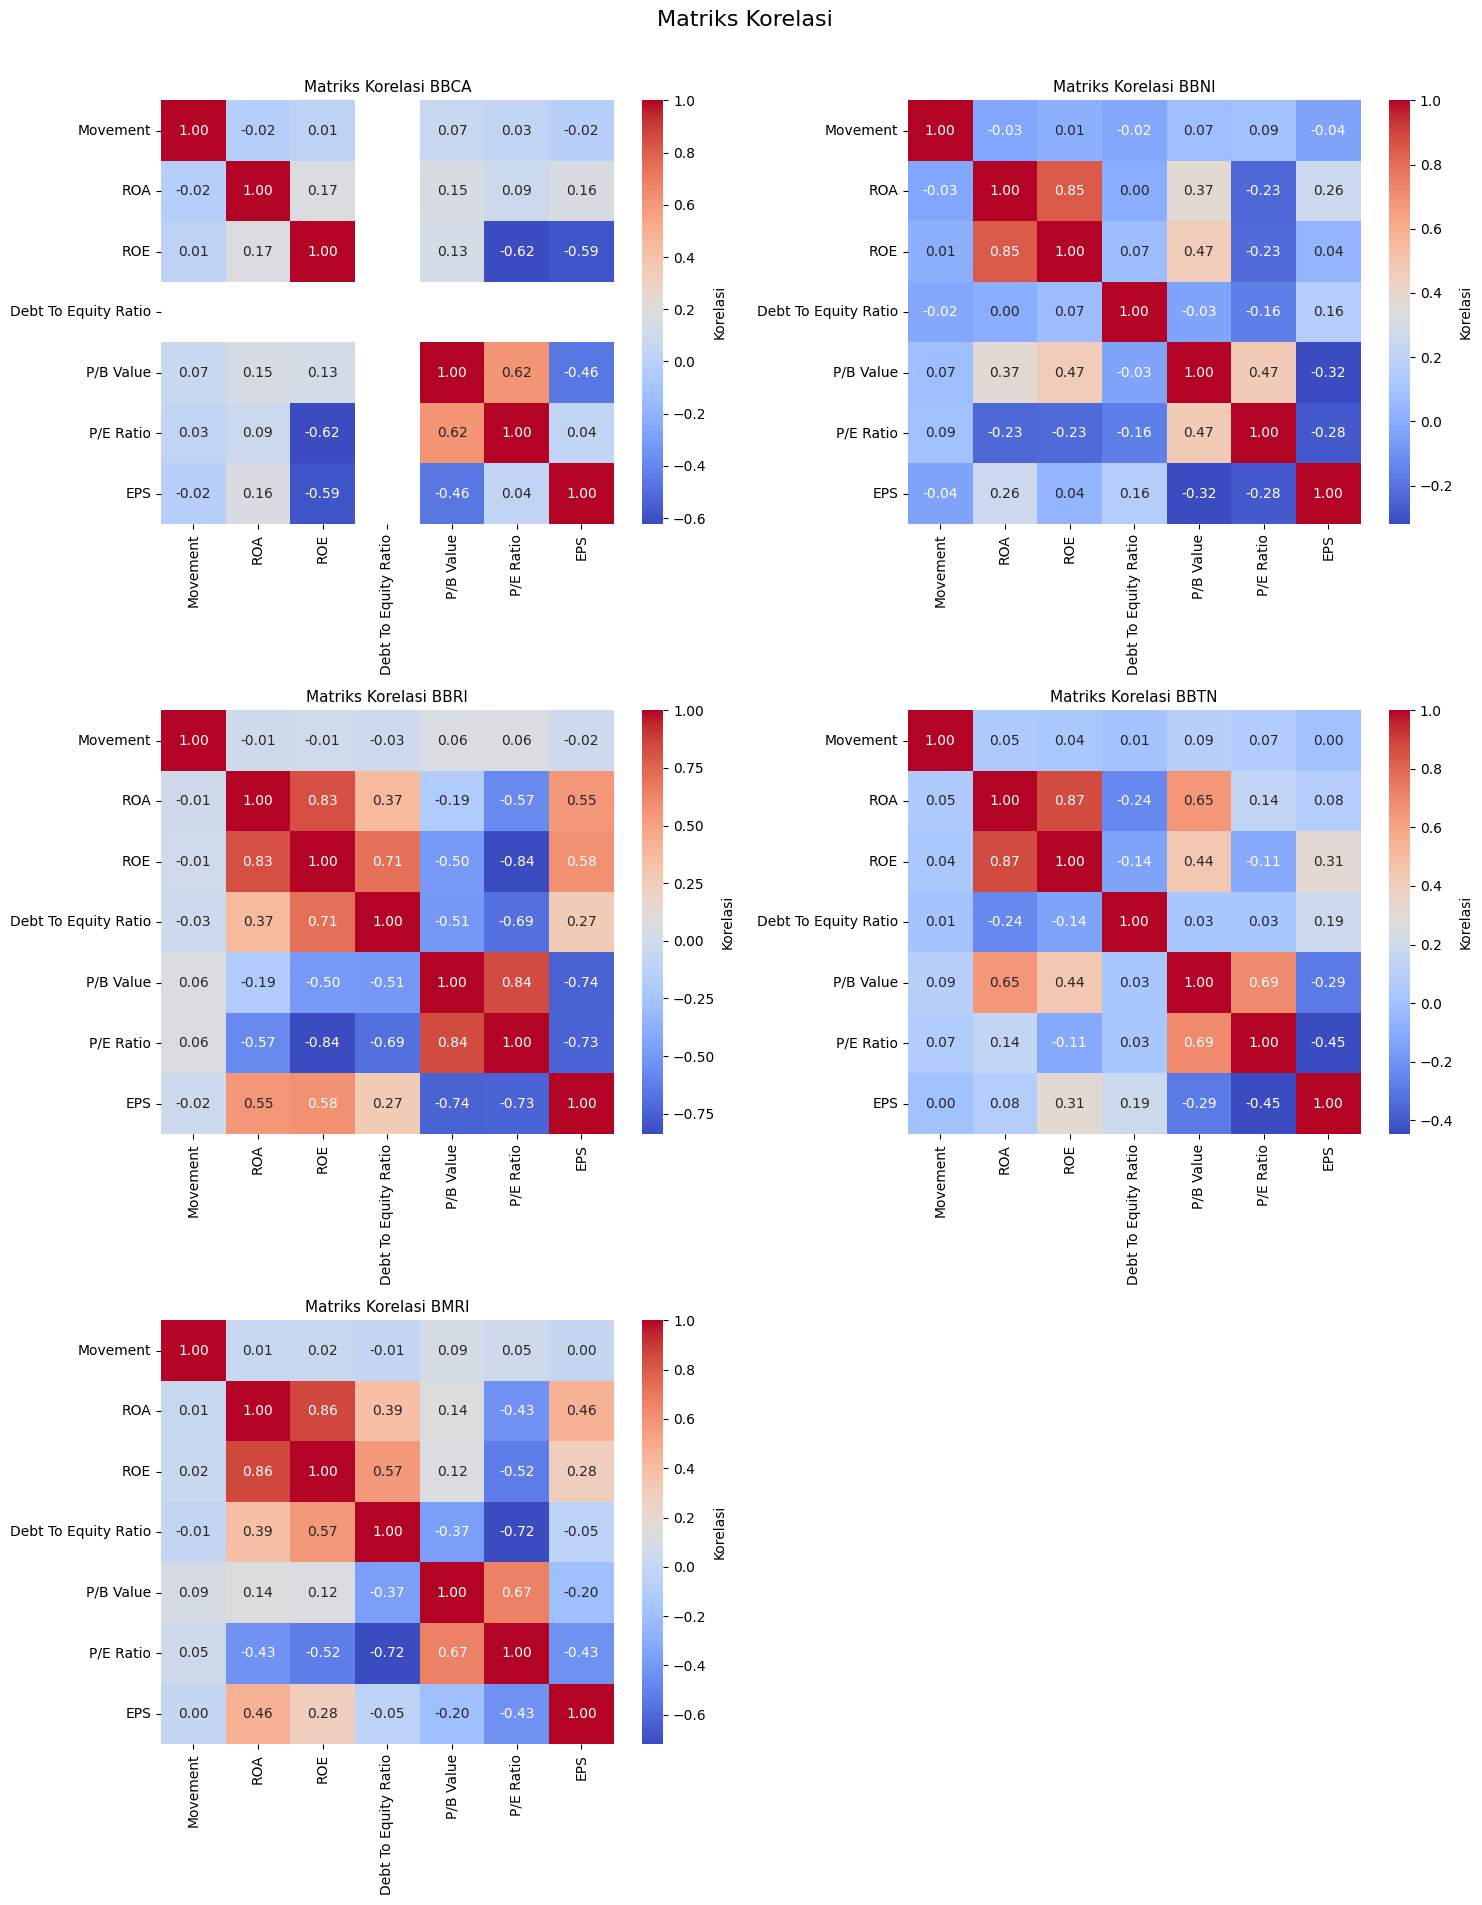

In [ ]:
# Loop through each file path, read the file, calculate returns, add 'movement', and store them
for file_path, company_name in zip(file_paths, company_names):
    # Read the Excel file
    data = pd.read_excel(file_path)

    # Calculate returns from the 'Close' column
    data['Return'] = data['Close'].pct_change() * 100

    # Add 'movement' column based on threshold 2
    data['Movement'] = data['Return'].apply(
        lambda x: 1 if x > 2 else (-1 if x < -2 else 0)
    )

    # Store the data in the dictionary
    company_returns[company_name] = data

# Set up the figure for plotting without shared x-axis
fig, axes = plt.subplots(3, 2, figsize=(15, 20))  # Removed `sharex=True`
fig.suptitle('Matriks Korelasi', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each company's correlation matrix
for idx, (company_name, data) in enumerate(company_returns.items()):
    # Select only numeric columns and drop 'Close' column
    numeric_data = data.select_dtypes(include=['number']).drop(columns=['Close', 'Return'])

    # Reorder columns: 'Return' and 'movement' first, and 'EPS' last (if 'EPS' exists)
    if 'EPS' in numeric_data.columns:
        cols = ['Movement'] + [col for col in numeric_data.columns if col not in ['Movement', 'EPS']] + ['EPS']
    else:
        cols = ['Movement'] + [col for col in numeric_data.columns if col not in ['Movement']]

    # Reorder columns in DataFrame
    numeric_data = numeric_data[cols]

    # Calculate correlation matrix using Spearman method
    correlation_matrix = numeric_data.corr(method='spearman')

    # Plot the heatmap of the correlation matrix
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[idx], cbar_kws={'label': 'Korelasi'})

    # Set title
    axes[idx].set_title(f'Matriks Korelasi {company_name}', fontsize=11, fontweight='light')

# Hide any remaining unused subplots
for i in range(len(company_returns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

<ipython-input-48-18033a9016dc>:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


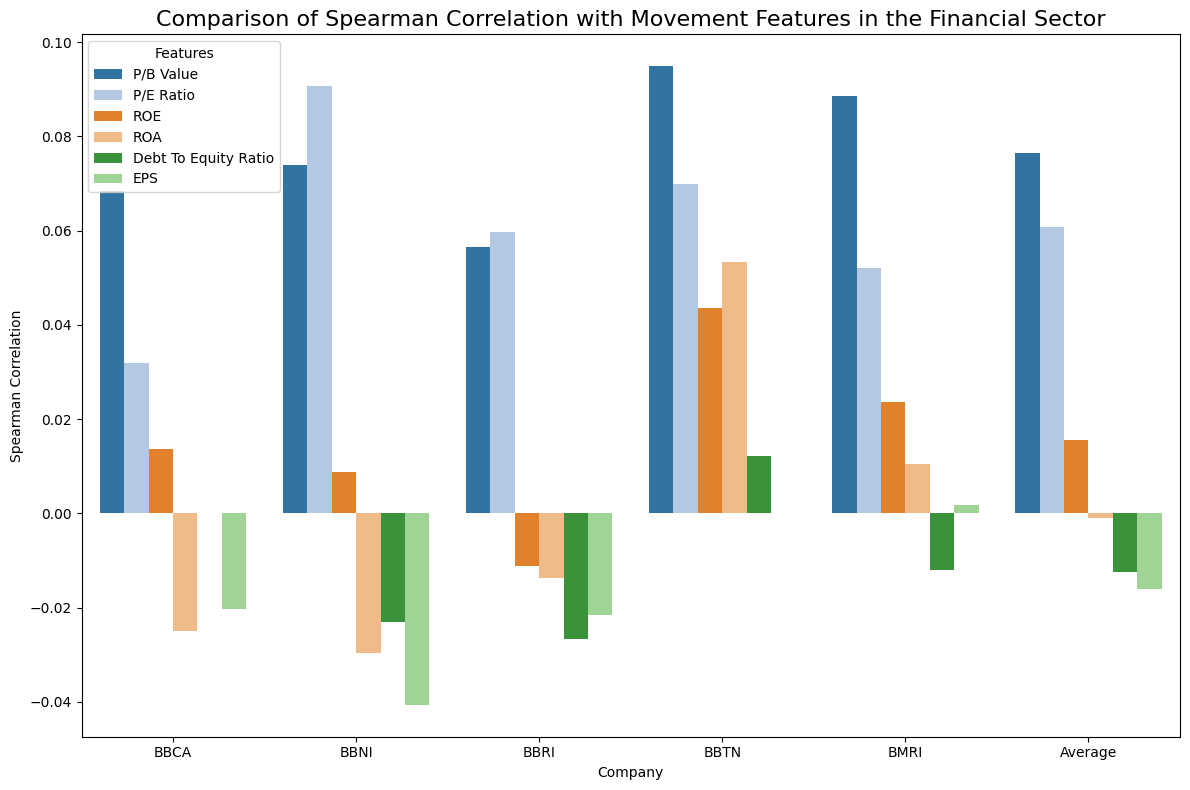

In [ ]:
# Dictionary to store correlation results for bar chart
correlation_results = {}

# Loop through each company's data to calculate correlations
for company_name, data in company_returns.items():
    # Select only numeric columns and drop irrelevant ones
    numeric_data = data.select_dtypes(include=['number']).drop(columns=['Close', 'Return'], errors='ignore')

    # Calculate correlation matrix using Spearman method
    correlation_matrix = numeric_data.corr(method='spearman')

    # Extract correlation of features with 'Movement' column
    movement_correlation = correlation_matrix['Movement'].drop('Movement', errors='ignore')
    correlation_results[company_name] = movement_correlation

# Convert the dictionary into a DataFrame for plotting
correlation_df = pd.DataFrame(correlation_results)

# Calculate the average correlation for each feature
correlation_df['Average'] = correlation_df.mean(axis=1)

# Sort features by their average correlation
sorted_features = correlation_df.sort_values(by='Average', ascending=False).index

# Transpose and reset index for easier plotting
correlation_df = correlation_df.T
correlation_df.index.name = 'Company'
correlation_df.reset_index(inplace=True)

# Melt the DataFrame to long format for grouped bar chart
correlation_long = correlation_df.melt(id_vars='Company', var_name='Feature', value_name='Correlation')

# Ensure features are ordered based on the sorted averages
correlation_long['Feature'] = pd.Categorical(correlation_long['Feature'], categories=sorted_features, ordered=True)

# Define custom colors for each feature
feature_colors = {
    'EPS': 'cornflowerblue',
    'ROA': 'turquoise',
    'ROE': 'palegreen',
    'P/B Value': 'lightseagreen',
    'P/E Ratio': 'slateblue',
    'Debt To Equity Ratio': 'deeppink'
}

# Plot the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    data=correlation_long,
    x='Company',
    y='Correlation',
    hue='Feature',
    ci=None,
    palette='tab20'
)

# Customize plot
plt.title('Comparison of Spearman Correlation with Movement Features in the Financial Sector', fontsize=16)
plt.ylabel('Spearman Correlation')
plt.xlabel('Company')
plt.legend(title='Features', loc='upper left', frameon=True)
plt.tight_layout()

# Show plot
plt.show()

# Infrastruktur

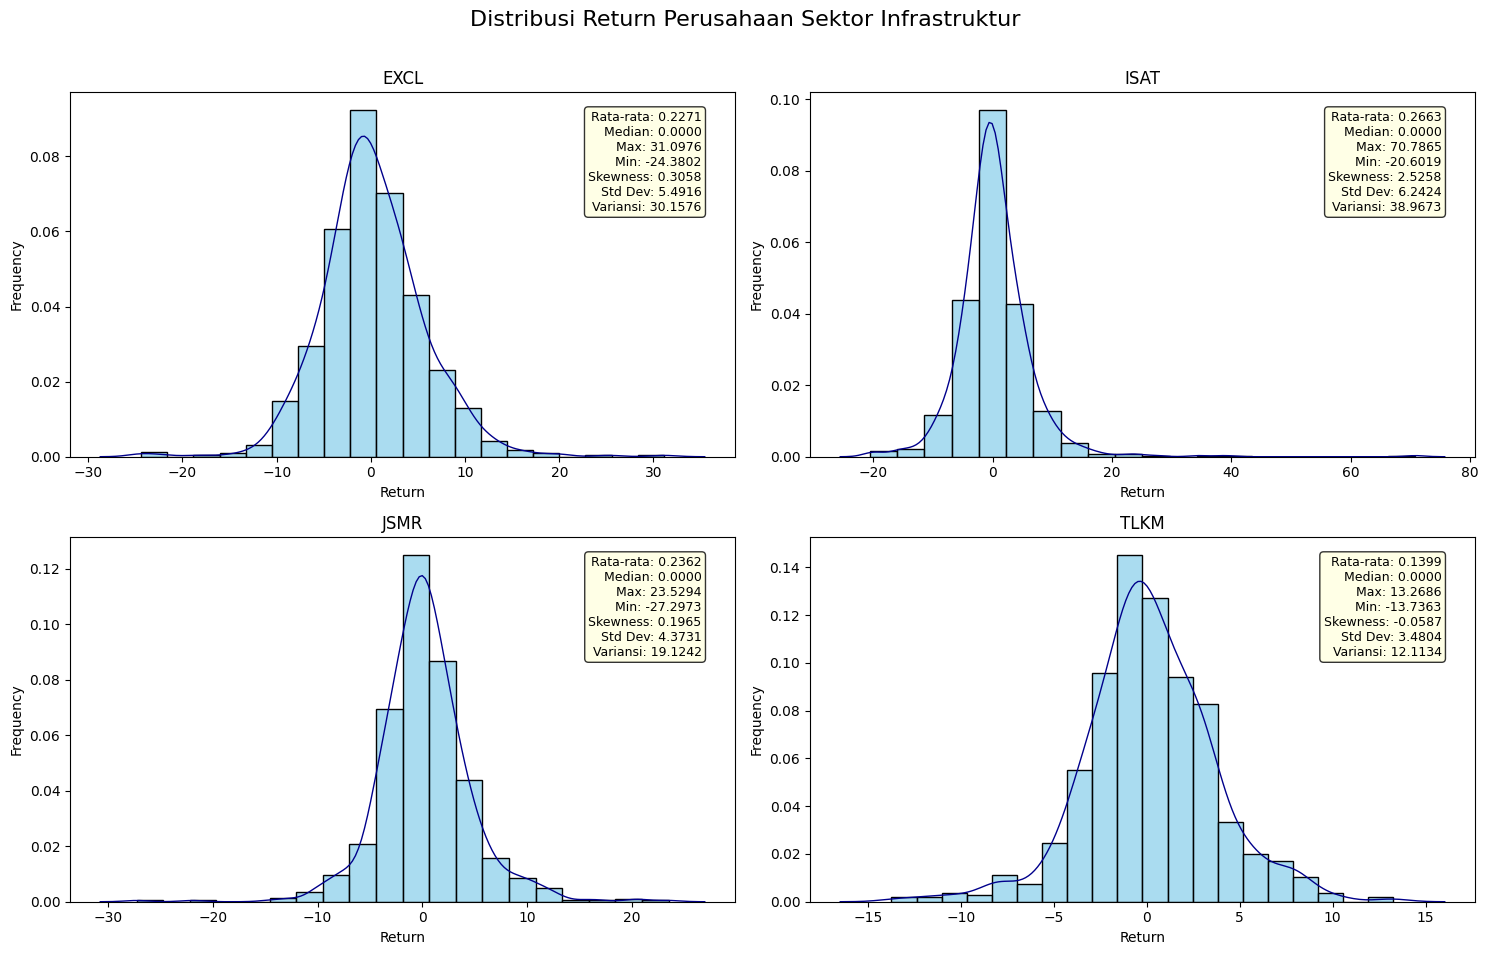

In [ ]:
company_returns = {}
company_names = ['EXCL', 'ISAT','JSMR','TLKM']

file_paths = [fr'/content/{company}_FINAL.xlsx' for company in company_names]

# Loop through each file path, read the file, calculate returns, and store them
for file_path, company_name in zip(file_paths, company_names):
    # Read the Excel file
    data = pd.read_excel(file_path)

    # Calculate returns from the 'Close' column
    data['Return'] = data['Close'].pct_change()*100

    # Drop NaN values and store the result in the dictionary
    company_returns[company_name] = data['Return'].dropna()

# Set up the figure for plotting without shared x-axis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # Removed `sharex=True`
fig.suptitle('Distribusi Return Perusahaan Sektor Infrastruktur', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each company's return distribution with customized KDE curve color
for idx, (company_name, returns) in enumerate(company_returns.items()):
    # Plot histogram with KDE
    sns.histplot(returns, bins=20, kde=False, ax=axes[idx], color='skyblue', edgecolor='black', alpha=0.7, stat='density')
    sns.kdeplot(returns, ax=axes[idx], color='darkblue', linewidth=1)

    # Calculate statistics
    avg_return = returns.mean()
    median_return = returns.median()
    max_return = returns.max()
    min_return = returns.min()
    skewness = skew(returns)
    std_dev = returns.std()
    variance = returns.var()

    # Annotate the statistics with enhanced formatting
    stats_text = (
        f'Rata-rata: {avg_return:.4f}\n'
        f'Median: {median_return:.4f}\n'
        f'Max: {max_return:.4f}\n'
        f'Min: {min_return:.4f}\n'
        f'Skewness: {skewness:.4f}\n'
        f'Std Dev: {std_dev:.4f}\n'
        f'Variansi: {variance:.4f}'
    )
    props = dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightyellow', alpha=0.8)
    axes[idx].text(0.95, 0.95, stats_text, transform=axes[idx].transAxes, fontsize=9,
                   verticalalignment='top', horizontalalignment='right', bbox=props, color='black')

    # Set title and labels
    axes[idx].set_title(company_name, fontsize=12, fontweight='light')
    axes[idx].set_xlabel('Return')
    axes[idx].set_ylabel('Frequency')

# Hide any remaining unused subplots
for i in range(len(company_returns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

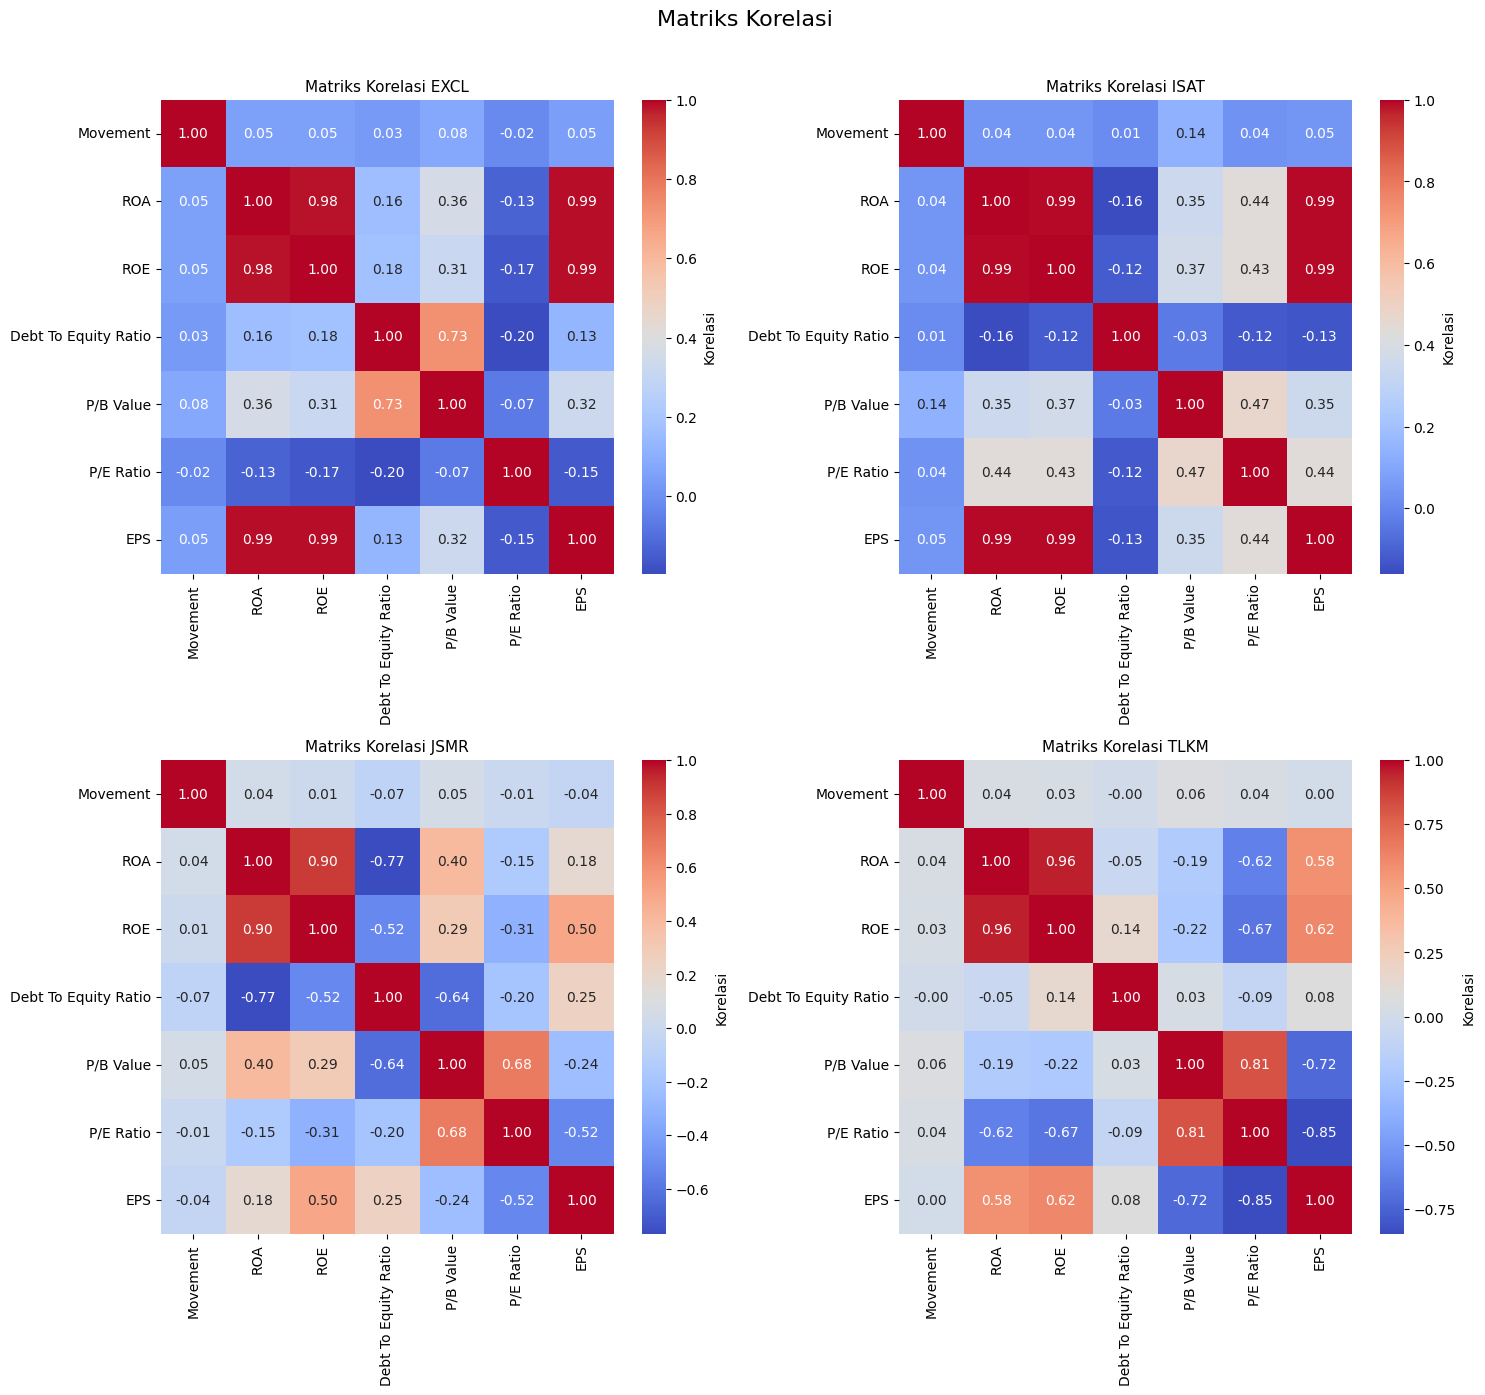

In [ ]:
# Loop through each file path, read the file, calculate returns, add 'movement', and store them
for file_path, company_name in zip(file_paths, company_names):
    # Read the Excel file
    data = pd.read_excel(file_path)

    # Calculate returns from the 'Close' column
    data['Return'] = data['Close'].pct_change() * 100

    # Add 'movement' column based on threshold 2
    data['Movement'] = data['Return'].apply(
        lambda x: 1 if x > 2 else (-1 if x < -2 else 0)
    )

    # Store the data in the dictionary
    company_returns[company_name] = data

# Set up the figure for plotting without shared x-axis
fig, axes = plt.subplots(3, 2, figsize=(15, 20))  # Removed `sharex=True`
fig.suptitle('Matriks Korelasi', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each company's correlation matrix
for idx, (company_name, data) in enumerate(company_returns.items()):
    # Select only numeric columns and drop 'Close' column
    numeric_data = data.select_dtypes(include=['number']).drop(columns=['Close', 'Return'])

    # Reorder columns: 'Return' and 'movement' first, and 'EPS' last (if 'EPS' exists)
    if 'EPS' in numeric_data.columns:
        cols = ['Movement'] + [col for col in numeric_data.columns if col not in ['Movement', 'EPS']] + ['EPS']
    else:
        cols = ['Movement'] + [col for col in numeric_data.columns if col not in ['Movement']]

    # Reorder columns in DataFrame
    numeric_data = numeric_data[cols]

    # Calculate correlation matrix using Spearman method
    correlation_matrix = numeric_data.corr(method='spearman')

    # Plot the heatmap of the correlation matrix
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[idx], cbar_kws={'label': 'Korelasi'})

    # Set title
    axes[idx].set_title(f'Matriks Korelasi {company_name}', fontsize=11, fontweight='light')

# Hide any remaining unused subplots
for i in range(len(company_returns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

<ipython-input-52-8013d0fa8457>:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


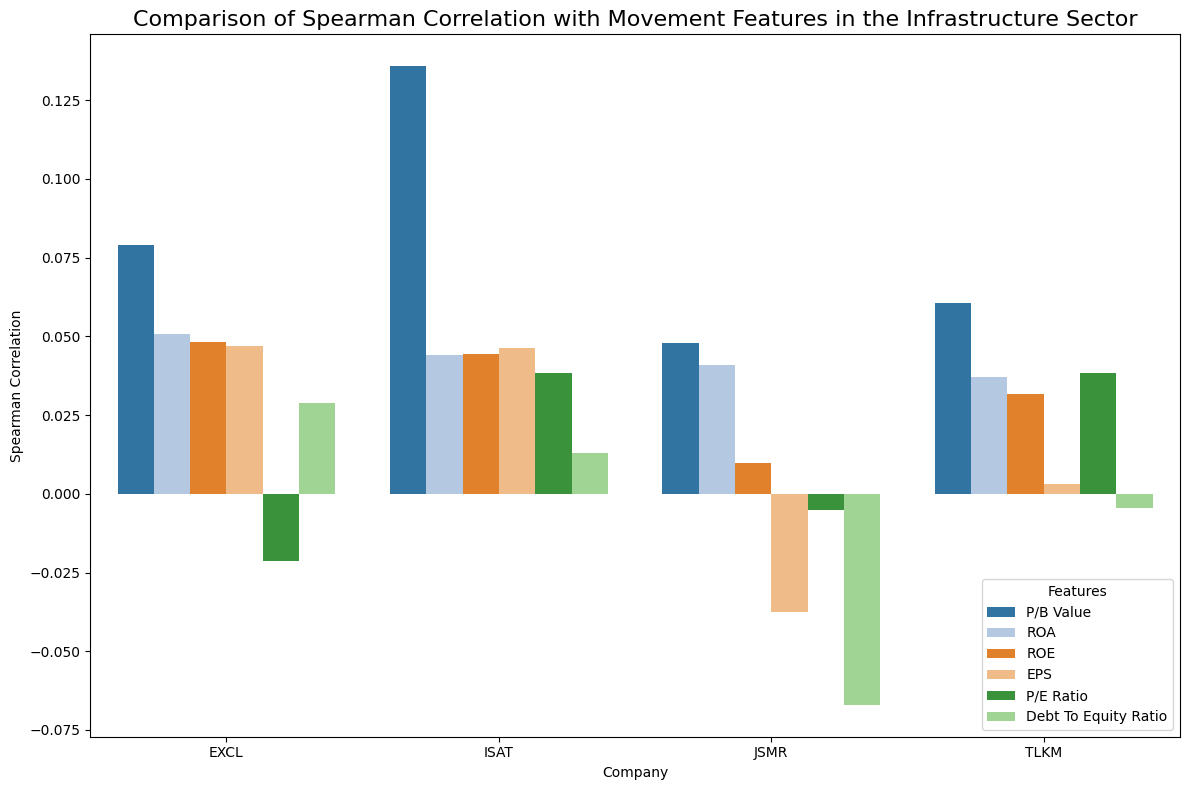

In [ ]:
# Dictionary to store correlation results for bar chart
correlation_results = {}

# Loop through each company's data to calculate correlations
for company_name, data in company_returns.items():
    # Select only numeric columns and drop irrelevant ones
    numeric_data = data.select_dtypes(include=['number']).drop(columns=['Close', 'Return'], errors='ignore')

    # Calculate correlation matrix using Spearman method
    correlation_matrix = numeric_data.corr(method='spearman')

    # Extract correlation of features with 'Movement' column
    movement_correlation = correlation_matrix['Movement'].drop('Movement', errors='ignore')
    correlation_results[company_name] = movement_correlation

# Convert the dictionary into a DataFrame for plotting
correlation_df = pd.DataFrame(correlation_results)

# Calculate the average correlation for each feature
correlation_df['Average'] = correlation_df.mean(axis=1)

# Sort features by their average correlation
sorted_features = correlation_df.sort_values(by='Average', ascending=False).index

# Drop the "Average" column to exclude it from the plot
correlation_df = correlation_df.drop(columns=['Average'], errors='ignore')

# Transpose and reset index for easier plotting
correlation_df = correlation_df.T
correlation_df.index.name = 'Company'
correlation_df.reset_index(inplace=True)

# Melt the DataFrame to long format for grouped bar chart
correlation_long = correlation_df.melt(id_vars='Company', var_name='Feature', value_name='Correlation')

# Ensure features are ordered based on the sorted averages
correlation_long['Feature'] = pd.Categorical(correlation_long['Feature'], categories=sorted_features, ordered=True)

# Define custom colors for each feature
feature_colors = {
    'EPS': 'cornflowerblue',
    'ROA': 'turquoise',
    'ROE': 'palegreen',
    'P/B Value': 'lightseagreen',
    'P/E Ratio': 'slateblue',
    'Debt To Equity Ratio': 'deeppink'
}

# Plot the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    data=correlation_long,
    x='Company',
    y='Correlation',
    hue='Feature',
    ci=None,
    palette='tab20'
)

# Customize plot
plt.title('Comparison of Spearman Correlation with Movement Features in the Infrastructure Sector', fontsize=16)
plt.ylabel('Spearman Correlation')
plt.xlabel('Company')
plt.legend(title='Features', loc='lower right', frameon=True)
plt.tight_layout()

# Show plot
plt.show()

# Barang Baku

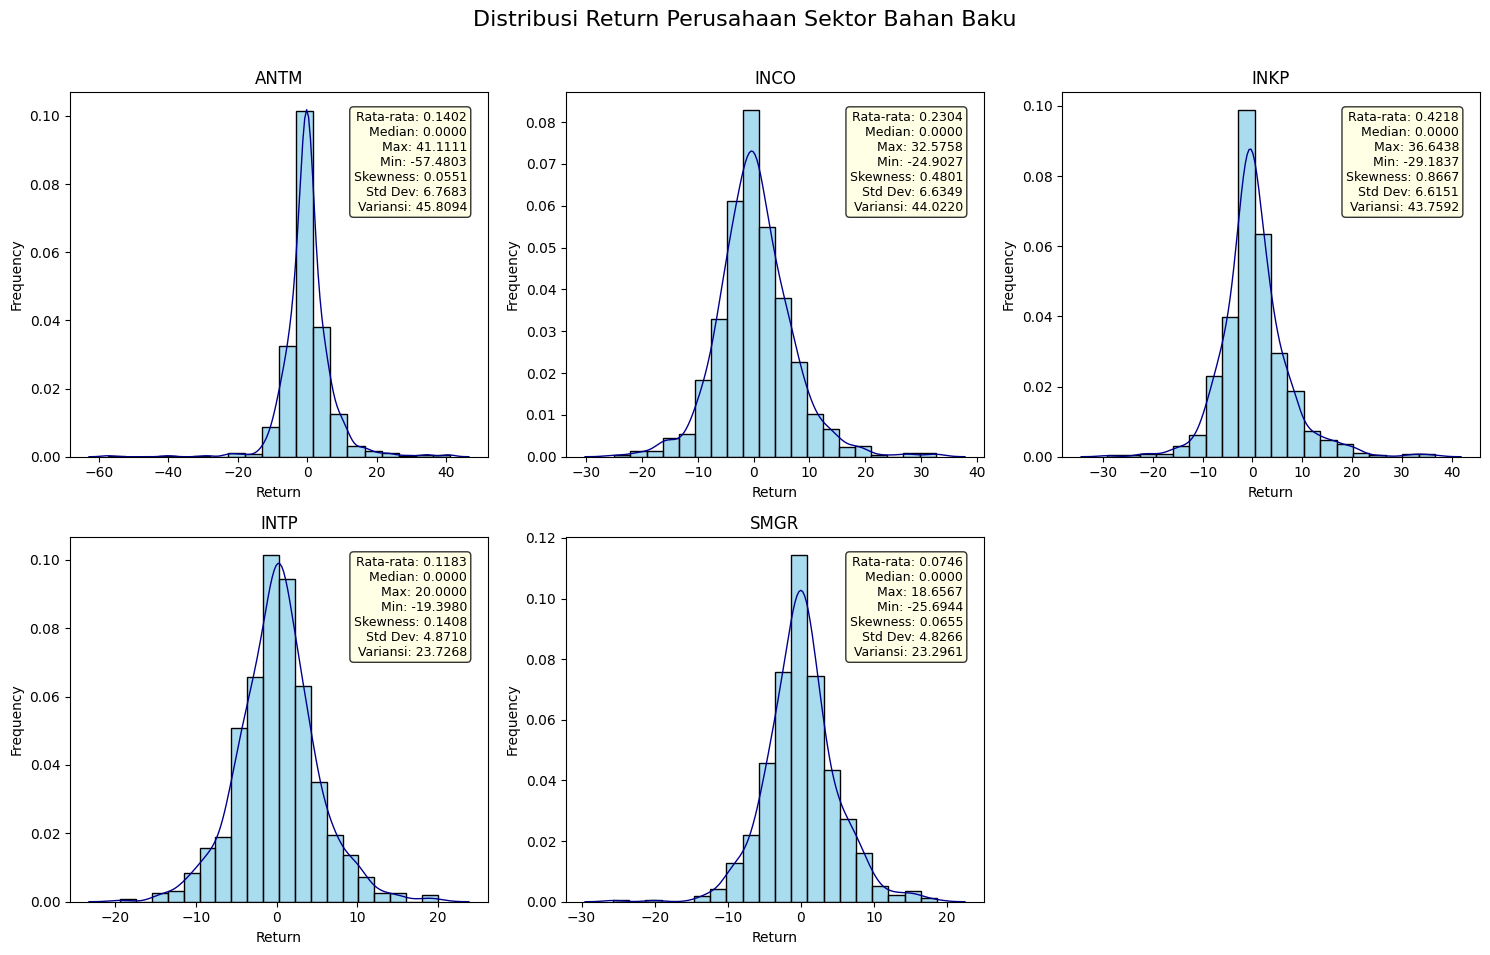

In [ ]:
company_returns = {}
company_names = ['ANTM','INCO','INKP','INTP','SMGR']

file_paths = [fr'/content/{company}_FINAL.xlsx' for company in company_names]

# Loop through each file path, read the file, calculate returns, and store them
for file_path, company_name in zip(file_paths, company_names):
    # Read the Excel file
    data = pd.read_excel(file_path)

    # Calculate returns from the 'Close' column
    data['Return'] = data['Close'].pct_change()*100

    # Drop NaN values and store the result in the dictionary
    company_returns[company_name] = data['Return'].dropna()

# Set up the figure for plotting without shared x-axis
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # Removed `sharex=True`
fig.suptitle('Distribusi Return Perusahaan Sektor Bahan Baku', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each company's return distribution with customized KDE curve color
for idx, (company_name, returns) in enumerate(company_returns.items()):
    # Plot histogram with KDE
    sns.histplot(returns, bins=20, kde=False, ax=axes[idx], color='skyblue', edgecolor='black', alpha=0.7, stat='density')
    sns.kdeplot(returns, ax=axes[idx], color='darkblue', linewidth=1)

    # Calculate statistics
    avg_return = returns.mean()
    median_return = returns.median()
    max_return = returns.max()
    min_return = returns.min()
    skewness = skew(returns)
    std_dev = returns.std()
    variance = returns.var()

    # Annotate the statistics with enhanced formatting
    stats_text = (
        f'Rata-rata: {avg_return:.4f}\n'
        f'Median: {median_return:.4f}\n'
        f'Max: {max_return:.4f}\n'
        f'Min: {min_return:.4f}\n'
        f'Skewness: {skewness:.4f}\n'
        f'Std Dev: {std_dev:.4f}\n'
        f'Variansi: {variance:.4f}'
    )
    props = dict(boxstyle='round,pad=0.3', edgecolor='black', facecolor='lightyellow', alpha=0.8)
    axes[idx].text(0.95, 0.95, stats_text, transform=axes[idx].transAxes, fontsize=9,
                   verticalalignment='top', horizontalalignment='right', bbox=props, color='black')

    # Set title and labels
    axes[idx].set_title(company_name, fontsize=12, fontweight='light')
    axes[idx].set_xlabel('Return')
    axes[idx].set_ylabel('Frequency')

# Hide any remaining unused subplots
for i in range(len(company_returns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

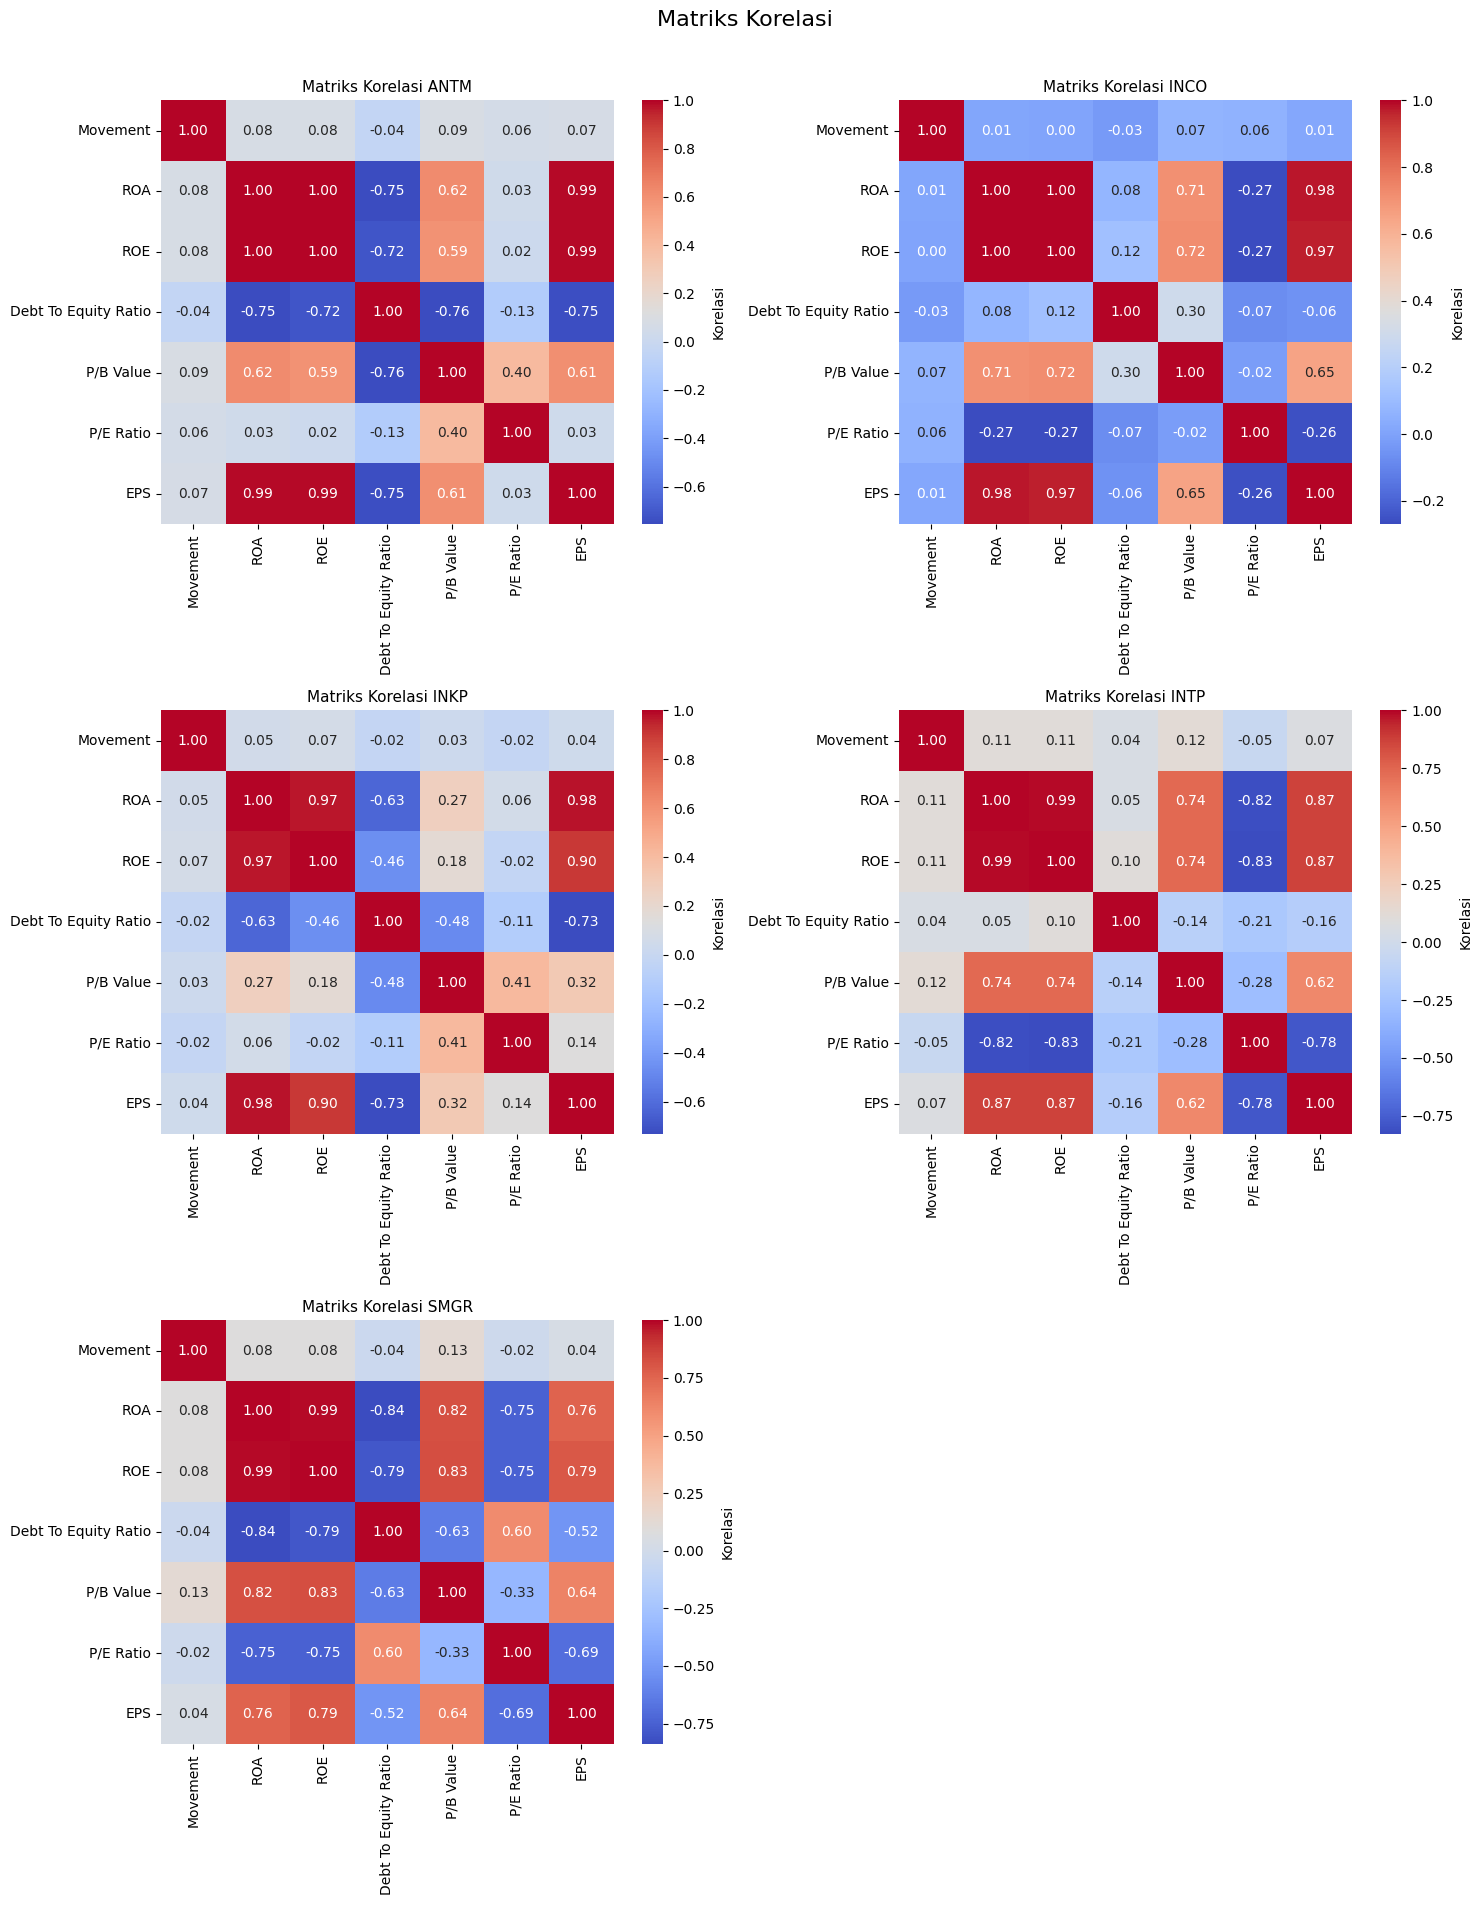

In [ ]:
# Loop through each file path, read the file, calculate returns, add 'movement', and store them
for file_path, company_name in zip(file_paths, company_names):
    # Read the Excel file
    data = pd.read_excel(file_path)

    # Calculate returns from the 'Close' column
    data['Return'] = data['Close'].pct_change() * 100

    # Add 'movement' column based on threshold 2
    data['Movement'] = data['Return'].apply(
        lambda x: 1 if x > 2 else (-1 if x < -2 else 0)
    )

    # Store the data in the dictionary
    company_returns[company_name] = data

# Set up the figure for plotting without shared x-axis
fig, axes = plt.subplots(3, 2, figsize=(15, 20))  # Removed `sharex=True`
fig.suptitle('Matriks Korelasi', fontsize=16)

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each company's correlation matrix
for idx, (company_name, data) in enumerate(company_returns.items()):
    # Select only numeric columns and drop 'Close' column
    numeric_data = data.select_dtypes(include=['number']).drop(columns=['Close', 'Return'])

    # Reorder columns: 'Return' and 'movement' first, and 'EPS' last (if 'EPS' exists)
    if 'EPS' in numeric_data.columns:
        cols = ['Movement'] + [col for col in numeric_data.columns if col not in ['Movement', 'EPS']] + ['EPS']
    else:
        cols = ['Movement'] + [col for col in numeric_data.columns if col not in ['Movement']]

    # Reorder columns in DataFrame
    numeric_data = numeric_data[cols]

    # Calculate correlation matrix using Spearman method
    correlation_matrix = numeric_data.corr(method='spearman')

    # Plot the heatmap of the correlation matrix
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[idx], cbar_kws={'label': 'Korelasi'})

    # Set title
    axes[idx].set_title(f'Matriks Korelasi {company_name}', fontsize=11, fontweight='light')

# Hide any remaining unused subplots
for i in range(len(company_returns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

<ipython-input-56-ddbf93e18ea7>:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


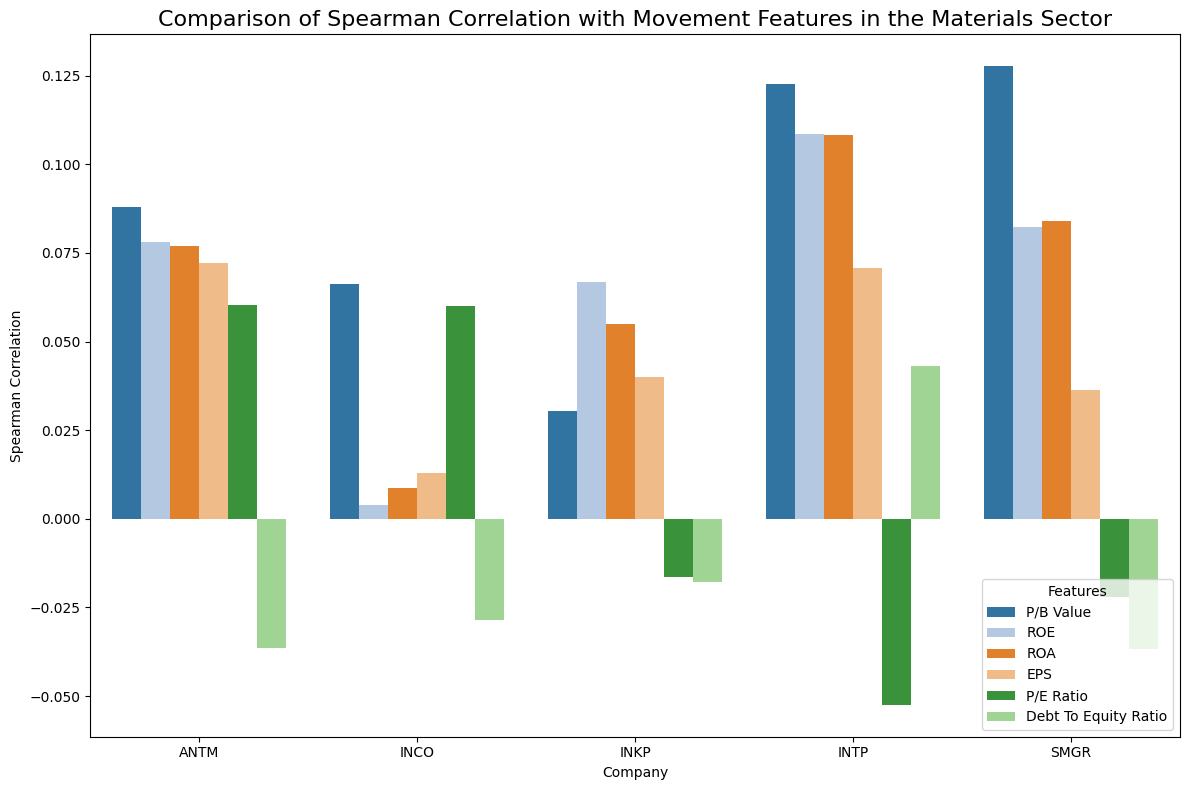

In [ ]:
# Dictionary to store correlation results for bar chart
correlation_results = {}

# Loop through each company's data to calculate correlations
for company_name, data in company_returns.items():
    # Select only numeric columns and drop irrelevant ones
    numeric_data = data.select_dtypes(include=['number']).drop(columns=['Close', 'Return'], errors='ignore')

    # Calculate correlation matrix using Spearman method
    correlation_matrix = numeric_data.corr(method='spearman')

    # Extract correlation of features with 'Movement' column
    movement_correlation = correlation_matrix['Movement'].drop('Movement', errors='ignore')
    correlation_results[company_name] = movement_correlation

# Convert the dictionary into a DataFrame for plotting
correlation_df = pd.DataFrame(correlation_results)

# Calculate the average correlation for each feature
correlation_df['Average'] = correlation_df.mean(axis=1)

# Sort features by their average correlation
sorted_features = correlation_df.sort_values(by='Average', ascending=False).index

# Drop the "Average" column to exclude it from the plot
correlation_df = correlation_df.drop(columns=['Average'], errors='ignore')

# Transpose and reset index for easier plotting
correlation_df = correlation_df.T
correlation_df.index.name = 'Company'
correlation_df.reset_index(inplace=True)

# Melt the DataFrame to long format for grouped bar chart
correlation_long = correlation_df.melt(id_vars='Company', var_name='Feature', value_name='Correlation')

# Ensure features are ordered based on the sorted averages
correlation_long['Feature'] = pd.Categorical(correlation_long['Feature'], categories=sorted_features, ordered=True)

# Define custom colors for each feature
feature_colors = {
    'EPS': 'cornflowerblue',
    'ROA': 'turquoise',
    'ROE': 'palegreen',
    'P/B Value': 'lightseagreen',
    'P/E Ratio': 'slateblue',
    'Debt To Equity Ratio': 'deeppink'
}

# Plot the bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    data=correlation_long,
    x='Company',
    y='Correlation',
    hue='Feature',
    ci=None,
    palette='tab20'
)

# Customize plot
plt.title('Comparison of Spearman Correlation with Movement Features in the Materials Sector', fontsize=16)
plt.ylabel('Spearman Correlation')
plt.xlabel('Company')
plt.legend(title='Features', loc='lower right', frameon=True)
plt.tight_layout()

# Show plot
plt.show()